![DBC](Images/DBC.png)

# ScholarScraper

**Introduction**

This script automates the process of scraping this information from Google Scholar for a list of authors. It utilizes [scholarly](https://pypi.org/project/scholarly/), a Python module that allows users to retrieve bibliometrics from [Google Scholar](https://scholar.google.ca/).

This project currently works with scholarly 1.4.5

**Installation and Setup**

1. Set-up Jupyter. If your institution has access, you can use [Syzygy](https://syzygy.ca/) to run in the Cloud, or install on your computer following [these instructions](https://jupyter.org/install).
2. Clone the project.
    - Open Terminal (in Syzygy, click the "+" button to open a new launcher and click "Terminal"
    - Type  "git clone https://github.com/ubcbraincircuits/ScholarScraper" and press enter
    - The project should now be cloned in your directory. 
    - Alternatively, you can download the project as a ZIP file from https://github.com/ubcbraincircuits/ScholarScraper (click Code, then Download ZIP)
3. [Install scholarly](https://pypi.org/project/scholarly/)
    - In the terminal (from above) type "pip install scholarly" or "pip install --user scholarly" and press enter
4. Obtain a CSV file with the list of author names in a single column with no column header. Ideally, all author names should match their names in Google Scholar. Upload this file to Syzygy or move it to the project folder on your computer. This file should be in the same directory as this notebook file (ScholarScraper.ipynb). 
5. Modify the names of the input/output files below (in step 1). The input file name must match the CSV file name. 
6. Modify the "affiliations" variable as a list of institution names which the researchers are affiliated with. Include both abbreviated and long form.  
7. Run all cells (click shift+enter to run a cell or the play button above). 
8. Open the ouput CSV file in the same directory as this notebook file. Check the last column of this file for warnings. If needed, modify the author names in the input CSV file if the wrong author profile was scraped, or no profile was found, and re-run.


In [2]:
from scholarly import scholarly
import csv
import warnings
import pandas as pd
import matplotlib.pyplot as plt


1. **Modify** the names of the input and output files. The name of the input file should match the name of the author list CSV file. If you followed the setup instructions, the CSV file should now be in the same directory as this notebook file. The output file does not have to exist yet (it will be created). 

In [3]:
input_authors = 'DBC-Authors.csv'
output_data = 'ss_output_data.csv'

2. Load in the author names from the CSV file. 

In [4]:
author_names= []
with open(input_authors, encoding ="utf-8-sig") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter =',')
    for row in csv_reader:
        if (len(row) == 1):
            author_names.append(row[0])
            

3. **Specify** the institution which the researchers are affiliated with. Tip: include long and abbreviated versions of institution names. Remember to use quotations!

In [5]:
affiliations = ["University of British Columbia", "UBC", "Djavad Mowafaghian", "Simon Fraser University",
                "University of Victoria", "University of Washington"]

4. Scrape data for each author

In [6]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for i, athr in enumerate(author_names):
    pubs = []
    search_query = scholarly.search_author(athr)
    try :
        author = next(search_query)
    except (RuntimeError,TypeError,StopIteration):
        row = {'Name': athr, 'Warning': 'no information found'}
    else:
        data_dict = scholarly.fill(author, sections=['basics', 'indices', 'publications', 'counts'])
        
        # Get publications. Add titles to dataframe and add authors to pub_authors dictionary
        for pub in data_dict['publications']:
            pubs.append(pub['bib']['title'])
            pub_authors.setdefault(pub['bib']['title'],[]).append(data_dict['name'])
        
        # Get citations per year and put in dictionary
        cites_per_year_dict = data_dict['cites_per_year']
        # Add name to dictionary 
        cites_per_year_dict['name'] = data_dict['name']
        cites_per_year.append(cites_per_year_dict)
        
        # Create row (dictionary) for output data table
        row = {'Name': data_dict['name'], 'Scholar ID': data_dict['scholar_id'], 
               'Cited by': data_dict['citedby'], 'Cited by 5 years': data_dict['citedby5y'], 
               'h-index': data_dict['hindex'], 'h-index 5 years': data_dict['hindex5y'], 
               'i10-index': data_dict['i10index'],'i10-index 5 years': data_dict['i10index5y'], 
               'Publications': pubs, 'Affiliation': data_dict['affiliation']}
        
        # Create list of authors who do not have the specified affiliation
        if not any(a in data_dict['affiliation'] for a in affiliations):
            row['Warning'] = "Affiliation does not match!"
            
    finally:    
        rows.append(row)
        
                

5. Add coauthors to the rows. 

In [7]:
# Create dictionary with author names as keys and dictionary (coauthor name as key, number of collaborations as value) 
#   as value
collabs_dict={}
for key in pub_authors:
    for author in pub_authors[key]:
        for coauthor in pub_authors[key]:
            if coauthor is not author:
                if author not in collabs_dict.keys() or coauthor not in collabs_dict[author].keys():
                    collabs_dict.setdefault(author,{})[coauthor]=1
                else:
                    collabs_dict[author][coauthor]+=1


# Write to rows dataframe
for row in rows:
    if row['Name'] in collabs_dict.keys():
        row['Coauthors'] = collabs_dict[row['Name']]
                

        

6. Write rows to output CSV file

In [8]:
# Specify the order of the data. These keys must match the names of the keys in the rows dictionary. 
keys = ['Name', 'Scholar ID', 'Cited by', 'Cited by 5 years', 'h-index', 'h-index 5 years',  'i10-index', 'i10-index 5 years', 'Publications', 'Coauthors', 'Affiliation', 'Warning']

# This creates/opens the file with filename with the intention to write to the csv_file
# The encoding allows the characters to be properly written to the csv_file
with open(output_data, mode='w', encoding ="utf-8") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)



7. Create barplot of citations per year. 

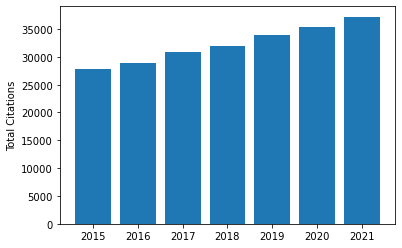

In [12]:
# Create citations per year dataframe
cites_df = pd.DataFrame(cites_per_year)

# Add a totals column
cites_df.loc['Total']= cites_df.sum()

# Select years to plot
cites_df_selected = cites_df[[2015,2016,2017,2018,2019,2020,2021]]

# Select the last row (totals) 
cites_df_total = cites_df_selected.iloc[-1:]

# Create barplot
years = list(cites_df_total.columns)
cites = cites_df_total.values.tolist()[0]
plt.bar(years, cites )
plt.ylabel('Total Citations')
plt.savefig("citations.pdf")